## Class 7 Agenda:
  * **Brief introduction to unsupervised learning**
  * **K-means clustering**
  * **Evaluating the quality of clustering using Silhouette coefficient**
  * **DBScan**
  * **Distance metrics and how to not misuse them**

|             | **Supervised**     | **Unsupervised**      |
|-------------|----------------|-------------------|
| **Continuous**  | Regression     | **<font color='red'>Clustering</font>**, PCA   |
| **Categorical** | Classification | Association Rules |

### Unsupervised learning

In the last class, we talked about the case where we knew what we were trying to predict.

We built a model to try to predict the expected gas mileage of a car model, given certain properties of the car (**supervised regression problem**) and a different model to try to predict whether someone had a spinal abnormality given certain measurements of their back and spine (**supervised classification problem**).

Both of these were labeled machine learning problems.

What if you didn't have any labels for your data but still wanted to see if there was any structure to your dataset? This process is called **unsupervised learning**. We are trying to learn something about our dataset without having access to any outcomes variables (targets, outputs, etc.).

We are going to explore 2 common approaches for **unsupervised learning**, called **K-means clustering** and **DBSCAN**.

By the end of this lesson you will be able to:
  * use k-means and DBSCAN clustering on new data
  * explain what the k-parameter in k-means does
  * explain what $\epsilon$ and min_samples parameters in DBSCAN affect
  * use euclidean distance for numerical clustering, know what kind of data to use euclidean distance with.

As always, we are going to import everything we need for the lesson:

In [1]:
from __future__ import print_function

#getting and working with data
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
from sklearn.metrics.cluster import silhouette_score

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

### K-means

The dataset we will be using today is one of the classic datasets used in machine learning, known as the **iris dataset**. This dataset is small and very useful for investigating both clustering and classification problems, but we will be using it exclusively for clustering purposes.

You can read more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Iris). There are 4 features identifying each type of iris:
  1. sepal length in cm
  2. sepal width in cm
  3. petal length in cm
  4. petal width in cm
  
Going forward, we are going to assume we don't know the kind of iris each sample corresponds to:

In [3]:
# Can read more about the Iris dataset here: https://archive.ics.uci.edu/ml/datasets/Iris
# Data Set Information: This is perhaps the best known database to be found in the pattern recognition literature. 
# Fisher's paper is a classic in the field and is referenced frequently to this day. The data set contains 3 classes 
# of 50 instances each, where each class refers to a type of iris plant. One class is linearly separable from the 
# other 2; the latter are NOT linearly separable from each other. 
# Predicted attribute: class of iris plant. 
# This is an exceedingly simple domain. 

# Attribute Information:

# 1. sepal length in cm 
# 2. sepal width in cm 
# 3. petal length in cm 
# 4. petal width in cm 
# 5. class: 
# -- Iris Setosa 
# -- Iris Versicolour 
# -- Iris Virginica

#We're getting the data directly off the internet here! how cool is that!
iris_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data",
                        names=["sepal_length","sepal_width","petal_length","petal_width","iris_type"])
iris_data_no_names = iris_data.drop("iris_type",axis=1)
# This data set has 5 different columns, but here we've dropped the 5th column (iris_type)
iris_data.head()

,sepal_length,sepal_width,petal_length,petal_width,iris_type
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
iris_data_features = iris_data_no_names.columns  # there are 150 rows
print(iris_data_features)
iris_data_no_names.head()
# we can do some test clusterings on this data set

Index([u'sepal_length', u'sepal_width', u'petal_length', u'petal_width'], dtype='object')


,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


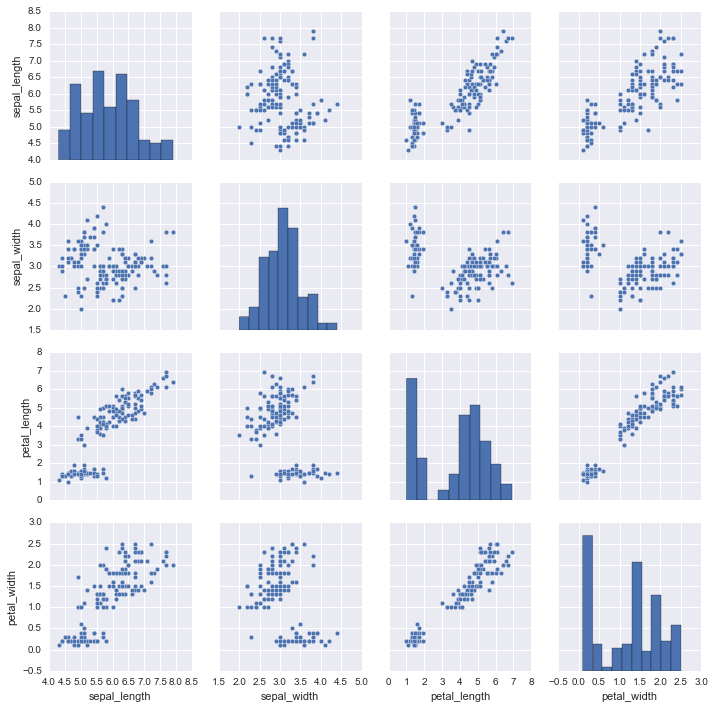

In [5]:
sns.pairplot(iris_data);

This dataset looks like it has some interesting structure! Let's see if we can't uncover and explore some of it.

At first pass, it looks like the dataset has at least 2 distinct clusters, right? So let's use k-means clustering to automatically find 2 clusters in the dataset:

**K-means clustering** takes a single parameter, which is the number of clusters you want the underlying data to fall into, and attempts to find those clusters automatically as follows:
  1. Initially generate random cluster centers equal to the number of clusters
  2. For each sample (row), label it with the cluster center it is closest to by computing the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between it and each cluster center
  3. Generate new cluster centers for each cluster based on the labelings for each point.
  4. Repeat steps 2-3 until one of the following stopping criteria is met: 
    * small fraction of samples change labelings
    * cluster centers change position by a very small amount.

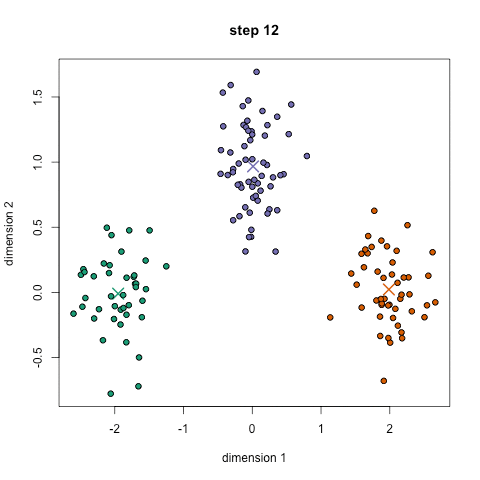

In [6]:
from IPython.display import Image, display
from IPython.core.display import clear_output

path = "../images/kmeans/"
files = [ "kmeans" + str(x) + ".png" for x in range(0,13) ]

f, ax = plt.subplots()

for imageName in files:
  clear_output()
  display(Image(filename=path+imageName))
  raw_input()
  # ax.cla() # turn this off if you'd like to "build up" plots -- yes, this works better. If I keep this on, it seems
# like the notebook or this particular cell will stall ....   
# this script will display images one at a time
plt.close() 
# This data set has 2 diff columns and 3 clusters

Before we look at the generated clusters for our dataset, we should understand how **euclidean distance** computes the distance between points in our dataset.

Here is the euclidean distance formula for finding the distance between two points, x and y, which have features i=1 to i=k (k features):

$d(x,y)=\sqrt {\sum_{i=1}^{k}(x_i-y_i)^2}$

So, it is simply the length of the path connecting them, as defined using the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem). It is simply finding the square of the difference on each feature, summing across all features, and taking the square root, to make the distance be "on the same scale" as the original measurement. (Think about what this means when the feature columns have vastly different scales).

### Example use of k-means - image compression

Take a 1 Megapixel image. Each pixel has 3 color values: R, G, and B, each is a number between 0 and 255 (aka 1 byte). So it takes 3 million bytes to specify the image.

We can turn an image into a data set by "unrolling" the pixels. Each pixel is a row and the dataset has 3 columns.

We could then use k-means to groups the pixels in groups. Then assign each pixel the RGB color of its centroid.

What if we used k = 16 groups? It takes half a byte per pixel to store this number. 

Space savings is 3 bytes/0.5 bytes = 6.

Here's an example:

![](../images/quant_kmeans_nature.jpg)

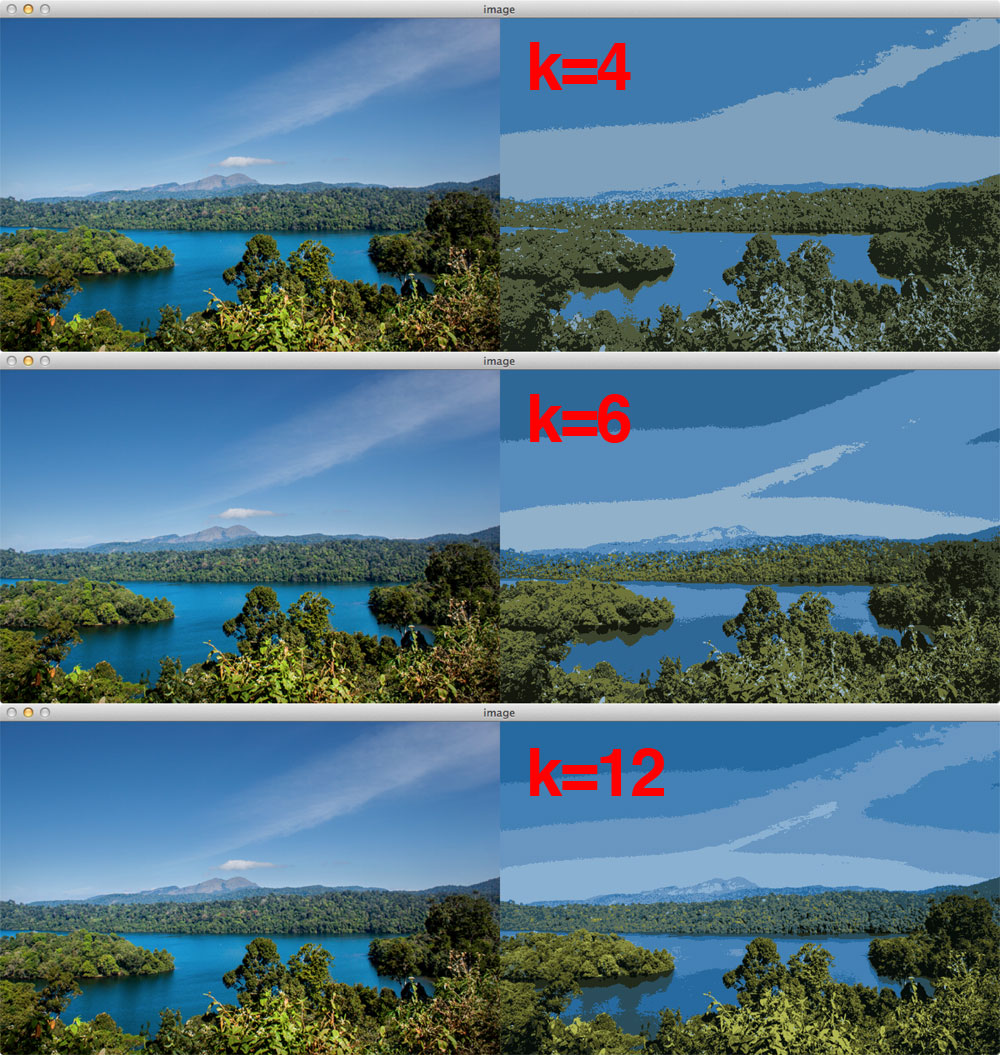

In [39]:
Image(filename = '../images/quant_kmeans_nature.jpg')
# Don't be confused; this is a completely separate example from the iris dataset example we're talking about

In [7]:
kmeans = KMeans(n_clusters=2,random_state=1234)
kmeans.fit(iris_data_no_names[iris_data_features])


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1234, tol=0.0001,
    verbose=0)

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
kmeans_2         object
dtype: object
   sepal_length  sepal_width  petal_length  petal_width   kmeans_2
0           5.1          3.5           1.4          0.2  cluster_0
1           4.9          3.0           1.4          0.2  cluster_0
2           4.7          3.2           1.3          0.2  cluster_0
3           4.6          3.1           1.5          0.2  cluster_0
4           5.0          3.6           1.4          0.2  cluster_0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]


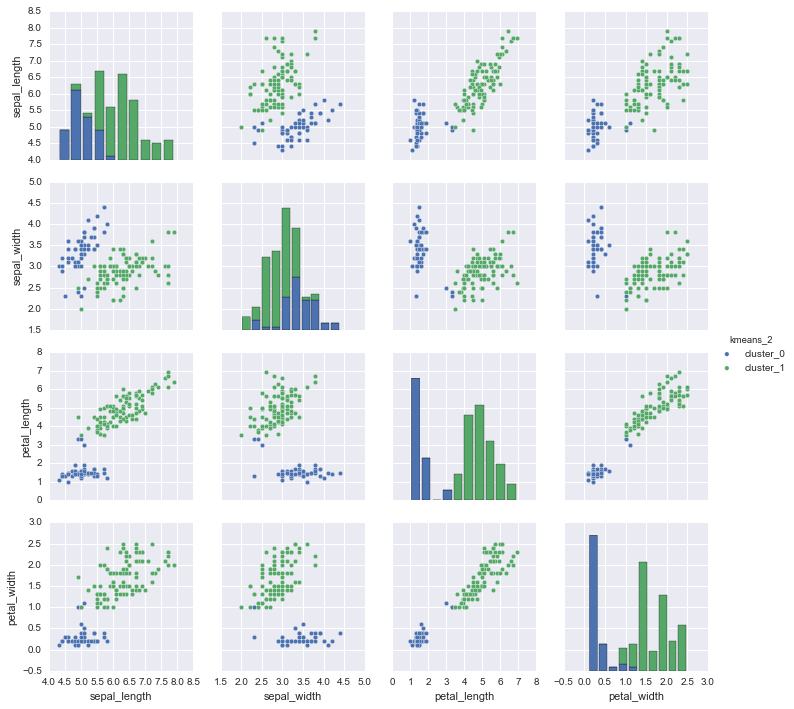

In [8]:
iris_data_no_names["kmeans_2"] = ["cluster_"+str(label) for label in kmeans.labels_]  # We're adding a new column to
# the dataset
print(iris_data_no_names.dtypes) 
print(iris_data_no_names.head())
print(kmeans.labels_)
sns.pairplot(iris_data_no_names,hue="kmeans_2");

In [9]:
print("Cluster centers found by k-means:\n" + ", ".join(iris_data_features) + "\n",
      kmeans.cluster_centers_)

Cluster centers found by k-means:
sepal_length, sepal_width, petal_length, petal_width
 [[ 5.00566038  3.36981132  1.56037736  0.29056604]
 [ 6.30103093  2.88659794  4.95876289  1.69587629]]


In [10]:
kmeans.cluster_centers_

array([[ 5.00566038,  3.36981132,  1.56037736,  0.29056604],
       [ 6.30103093,  2.88659794,  4.95876289,  1.69587629]])

In [11]:
iris_2_cluster_centers = iris_data_no_names.groupby("kmeans_2").mean()
print("Means of each column :\n",iris_2_cluster_centers.values)

Means of each column :
 [[ 5.00566038  3.36981132  1.56037736  0.29056604]
 [ 6.30103093  2.88659794  4.95876289  1.69587629]]


Let's plot the cluster centers on one of the plots we found above:

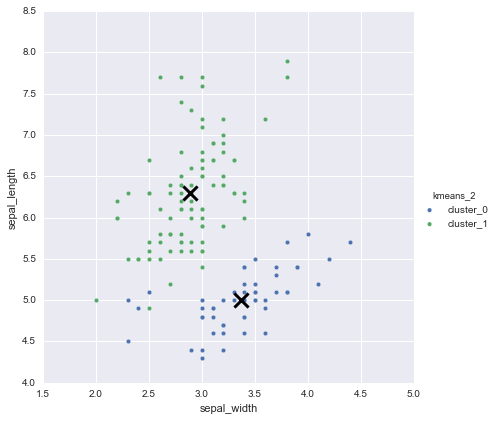

In [12]:
sns.pairplot(iris_data_no_names,x_vars="sepal_width",y_vars="sepal_length",hue="kmeans_2",size=6)
plt.scatter(iris_2_cluster_centers.sepal_width, iris_2_cluster_centers.sepal_length, linewidths=3, marker='x', s=200, c='black');
# Recall that:
# hue : string (variable name), optional -- Variable in ``data`` to map plot aspects to different colors.

Why are some of the points labeled strangely relative to what you would expect the overall position of the cluster centers?

**K-means** is the first algorithm we will use that **is affected by the scale of every feature**, by virtue of the fact that it uses a single distance metric (euclidean distance) across all features.

In practice, this means that for two features with very different scales of values one feature's contribution to the overall distance can dominate all distances found in the other feature:
  - Given 2 features and their original scales (difference between maximum and minimum values):
    - size in milliimeters
    - weight in kilograms
  - Distances in peoples sizes (which can vary 2 feet, about ~600mm) will dominate differences in peoples weight (which vary usually no more than ~50kg across people) because the relative scale is ~10x larger for sizes than kilograms.

What this means is that **for k-means clustering, features must be scaled to the same ranges of values to contribute "equally" to the euclidean distance calculation**.

How do we do this in practice?
We convert each sample's original value to its z-scored value:

$z_i = \frac{x_i - \mu}{\sigma}$

So, each row is transformed per-column by:
  - subtracting from the element in each row the mean for each feature (column) and then taking this value and
  - dividing by that feature's (column's) standard deviation.

Z-scoring our data allows us to compare values across columns.
Here's the two-line way of generating z-scores for our data:

In [13]:
print(iris_data_no_names.head())
iris_data_features

   sepal_length  sepal_width  petal_length  petal_width   kmeans_2
0           5.1          3.5           1.4          0.2  cluster_0
1           4.9          3.0           1.4          0.2  cluster_0
2           4.7          3.2           1.3          0.2  cluster_0
3           4.6          3.1           1.5          0.2  cluster_0
4           5.0          3.6           1.4          0.2  cluster_0


Index([u'sepal_length', u'sepal_width', u'petal_length', u'petal_width'], dtype='object')

In [14]:
# center and scale the data
scaler = StandardScaler()   # we create a StandardScalar
iris_data_scaled = scaler.fit_transform(iris_data_no_names[iris_data_features])
iris_data_scaled = pd.DataFrame(iris_data_scaled,columns=iris_data_features)
print("Before scaling:\n", iris_data_no_names[iris_data_features].describe())   # printing out some descriptive stats
print("\nAfter scaling:\n", np.round(iris_data_scaled.describe(),2))      # we subtracted out the mean from every col.

Before scaling:
        sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

After scaling:
        sepal_length  sepal_width  petal_length  petal_width
count        150.00       150.00        150.00       150.00
mean          -0.00        -0.00         -0.00        -0.00
std            1.00         1.00          1.00         1.00
min           -1.87        -2.43         -1.57        -1.45
25%           -0.90        -0.59         -1.23        -1.18
50%           -0.05        -0.13          0.34         0.13
75%   

In [15]:
# K-means on scaled data
km = KMeans(n_clusters=2,random_state=1234)
km.fit(iris_data_scaled)  # we train the model here
iris_data_no_names['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km.labels_ ]
print(km)
print(km.cluster_centers_)
iris_data_no_names.groupby('kmeans_2_scaled').mean().reset_index()

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1234, tol=0.0001,
    verbose=0)
[[-1.01457897  0.85326268 -1.30498732 -1.25489349]
 [ 0.50728948 -0.42663134  0.65249366  0.62744675]]


,kmeans_2_scaled,sepal_length,sepal_width,petal_length,petal_width
0,cluster_0,5.006,3.428,1.462,0.246
1,cluster_1,6.262,2.872,4.906,1.676


   sepal_length  sepal_width  petal_length  petal_width   kmeans_2  \
0           5.1          3.5           1.4          0.2  cluster_0   
1           4.9          3.0           1.4          0.2  cluster_0   
2           4.7          3.2           1.3          0.2  cluster_0   
3           4.6          3.1           1.5          0.2  cluster_0   
4           5.0          3.6           1.4          0.2  cluster_0   

  kmeans_2_scaled  
0       cluster_0  
1       cluster_0  
2       cluster_0  
3       cluster_0  
4       cluster_0  


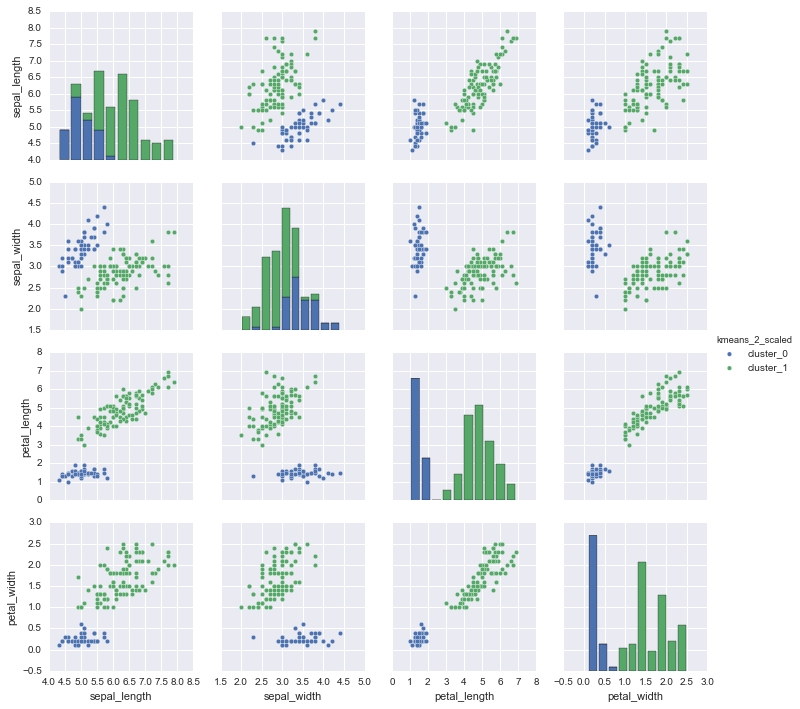

In [16]:
print(iris_data_no_names.head())
sns.pairplot(iris_data_no_names,hue="kmeans_2_scaled");  # to see what's really going on
# There's a much cleaner separation between the 2 clusters now ... they're much more cleanly separated

See the difference in cluster labels after scaling has been performed? The clusters are much cleaner!

What happens if we increase the number of clusters?

In [18]:
km3 = KMeans(n_clusters=3,random_state=1234)   # we set the number of different clusters to 3 now
km3.fit(iris_data_scaled)
iris_data_no_names['kmeans_3_scaled'] = [ "cluster_" + str(label) for label in km3.labels_ ]
print(km3.cluster_centers_)
iris_data_no_names.groupby('kmeans_3_scaled').mean().reset_index()

[[ 1.13140499  0.07903422  0.98537152  0.99908828]
 [-1.01457897  0.85326268 -1.30498732 -1.25489349]
 [-0.06881714 -0.89339955  0.34522179  0.28439302]]


,kmeans_3_scaled,sepal_length,sepal_width,petal_length,petal_width
0,cluster_0,6.777083,3.091667,5.491667,1.958333
1,cluster_1,5.006000,3.428000,1.462000,0.246000
2,cluster_2,5.786538,2.669231,4.365385,1.415385


KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1234, tol=0.0001,
    verbose=0)


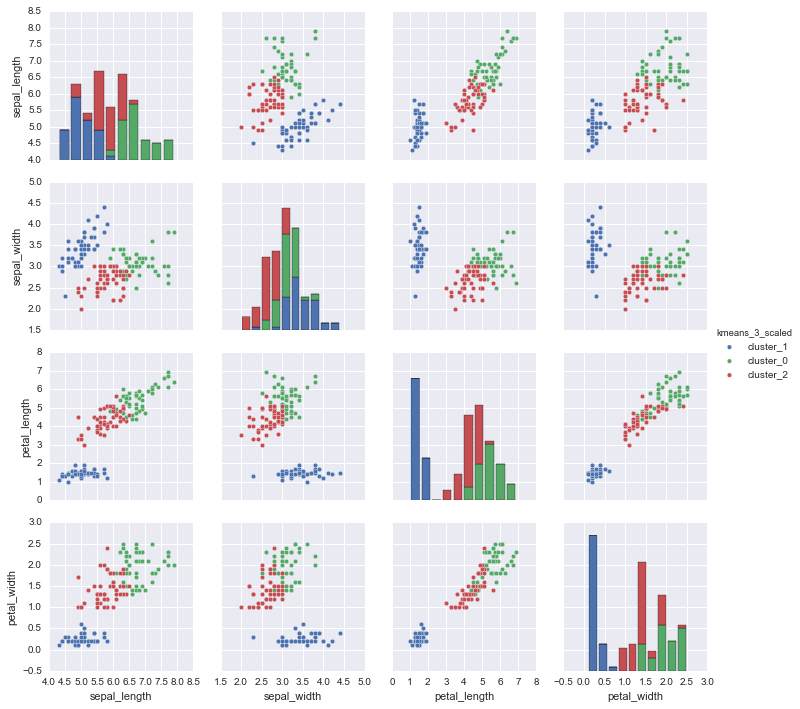

In [20]:
print(km3)
sns.pairplot(iris_data_no_names,hue="kmeans_3_scaled");
# impossible to know whether 2 or 3 is better by just looking at this plot

#### Exercise Time!!!
  * Generate k-means clustering for 4, 5, and 6 clusters.
  * How many samples are there per cluster for each clustering type?
  * How do you decide which number of clusters is best?

In [21]:
# pass
kmeans_4 = KMeans(n_clusters=4,random_state=1234)
kmeans_4.fit(iris_data_no_names[iris_data_features])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=4, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1234, tol=0.0001,
    verbose=0)

   sepal_length  sepal_width  petal_length  petal_width   kmeans_2  \
0           5.1          3.5           1.4          0.2  cluster_0   
1           4.9          3.0           1.4          0.2  cluster_0   
2           4.7          3.2           1.3          0.2  cluster_0   
3           4.6          3.1           1.5          0.2  cluster_0   
4           5.0          3.6           1.4          0.2  cluster_0   

  kmeans_2_scaled kmeans_3_scaled   kmeans_4  
0       cluster_0       cluster_1  cluster_0  
1       cluster_0       cluster_1  cluster_0  
2       cluster_0       cluster_1  cluster_0  
3       cluster_0       cluster_1  cluster_0  
4       cluster_0       cluster_1  cluster_0  
sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
kmeans_2            object
kmeans_2_scaled     object
kmeans_3_scaled     object
kmeans_4            object
dtype: object


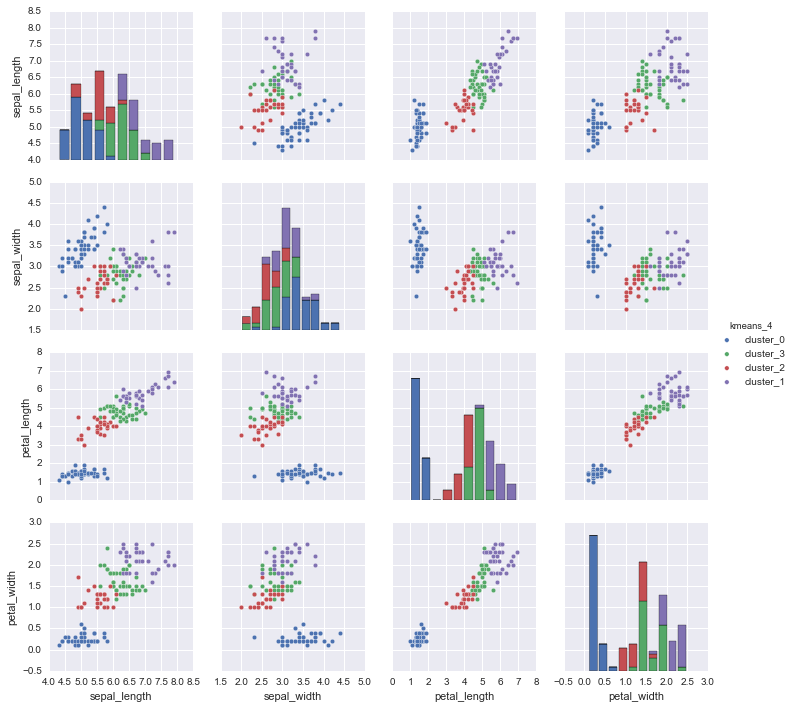

In [23]:
iris_data_no_names["kmeans_4"] = ["cluster_"+str(label) for label in kmeans_4.labels_]  # we're adding a new column to
print(iris_data_no_names.head())                                                        # the data
print(iris_data_no_names.dtypes)                                                        
sns.pairplot(iris_data_no_names,hue="kmeans_4");

In [27]:
print(kmeans_4.labels_)
print("Cluster centers found by k-means:\n" + ", ".join(iris_data_features) + "\n",
      kmeans_4.cluster_centers_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 3 3 2 3 2 3 2 3 2 2 2 2 3 2 3 3 2 3 2 3 2 3 3
 3 3 3 3 3 2 2 2 2 3 2 3 3 3 2 2 2 3 2 2 2 2 2 3 2 2 1 3 1 1 1 1 2 1 1 1 3
 3 1 3 3 1 1 1 1 3 1 3 1 3 1 1 3 3 1 1 1 1 1 3 3 1 1 1 3 1 1 1 3 1 1 1 3 3
 1 3]
Cluster centers found by k-means:
sepal_length, sepal_width, petal_length, petal_width
 [[ 5.006       3.428       1.462       0.246     ]
 [ 6.9125      3.1         5.846875    2.13125   ]
 [ 5.52962963  2.62222222  3.94074074  1.21851852]
 [ 6.23658537  2.85853659  4.80731707  1.62195122]]


In [28]:
iris_4_cluster_centers = iris_data_no_names.groupby("kmeans_4").mean()
print("Means of each column :\n",iris_4_cluster_centers.values)
print("--------------------")
print(iris_4_cluster_centers)
print("--------------------")
print(iris_4_cluster_centers.mean())

Means of each column :
 [[ 5.006       3.428       1.462       0.246     ]
 [ 6.9125      3.1         5.846875    2.13125   ]
 [ 5.52962963  2.62222222  3.94074074  1.21851852]
 [ 6.23658537  2.85853659  4.80731707  1.62195122]]
--------------------
           sepal_length  sepal_width  petal_length  petal_width
kmeans_4                                                       
cluster_0      5.006000     3.428000      1.462000     0.246000
cluster_1      6.912500     3.100000      5.846875     2.131250
cluster_2      5.529630     2.622222      3.940741     1.218519
cluster_3      6.236585     2.858537      4.807317     1.621951
--------------------
sepal_length    5.921179
sepal_width     3.002190
petal_length    4.014233
petal_width     1.304430
dtype: float64


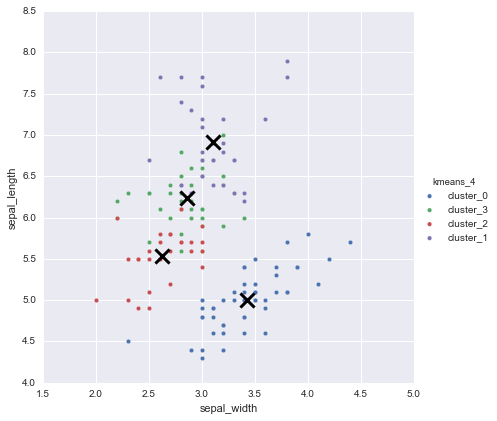

In [29]:
sns.pairplot(iris_data_no_names,x_vars="sepal_width",y_vars="sepal_length",hue="kmeans_4",size=6)
plt.scatter(iris_4_cluster_centers.sepal_width, iris_4_cluster_centers.sepal_length, linewidths=3, marker='x', s=200, c='black');

In [30]:
km_4 = KMeans(n_clusters=4,random_state=1234)
km_4.fit(iris_data_scaled)  # we train the model here
iris_data_no_names['kmeans_4_scaled'] = [ "cluster_" + str(label) for label in km_4.labels_ ]
print(km_4.cluster_centers_)
print(km_4.labels_)
iris_data_no_names.groupby('kmeans_4_scaled').mean().reset_index()
print(iris_data_no_names.head())

[[ 1.13140499  0.07903422  0.98537152  0.99908828]
 [-0.74922133  1.43007001 -1.29759846 -1.22142131]
 [-0.06881714 -0.89339955  0.34522179  0.28439302]
 [-1.35230687  0.11914427 -1.31439133 -1.29749445]]
[1 3 3 3 1 1 3 1 3 3 1 3 3 3 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 3 3 1 1 1 3 3 1
 1 3 1 1 3 3 1 1 3 1 3 1 3 0 0 0 2 2 2 0 2 0 2 2 2 2 2 2 0 2 2 2 2 0 2 2 2
 2 0 0 0 2 2 2 2 2 2 2 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 0 0 0 0 2 0 0 0 0
 0 0 2 2 0 0 0 0 2 0 2 0 2 0 0 2 0 0 0 0 0 0 2 2 0 0 0 2 0 0 0 2 0 0 0 2 0
 0 2]
   sepal_length  sepal_width  petal_length  petal_width   kmeans_2  \
0           5.1          3.5           1.4          0.2  cluster_0   
1           4.9          3.0           1.4          0.2  cluster_0   
2           4.7          3.2           1.3          0.2  cluster_0   
3           4.6          3.1           1.5          0.2  cluster_0   
4           5.0          3.6           1.4          0.2  cluster_0   

  kmeans_2_scaled kmeans_3_scaled   kmeans_4 kmeans_4_scaled  
0    

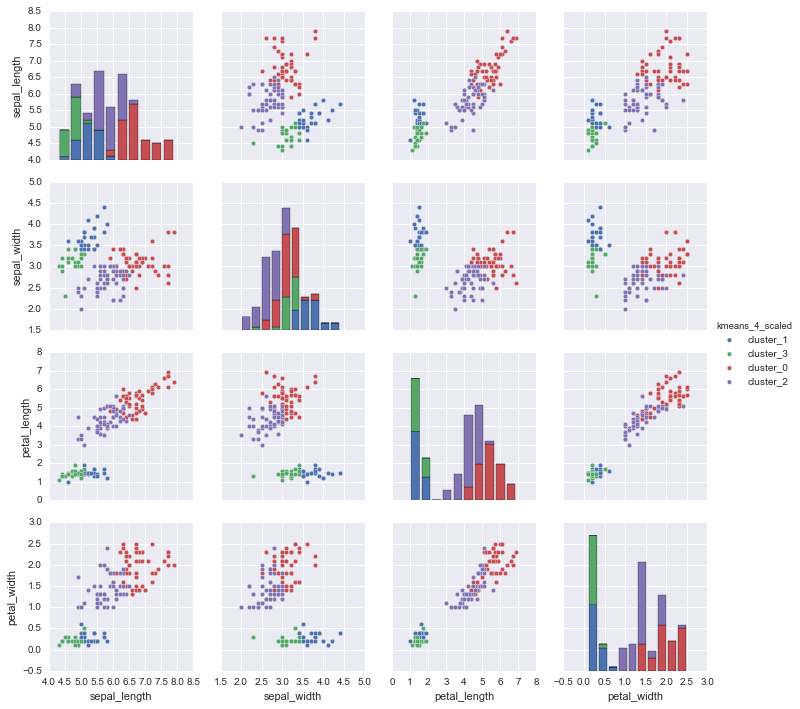

In [31]:
sns.pairplot(iris_data_no_names,hue="kmeans_4_scaled");  # to see what's really going on
# There's a much cleaner separation between the 4 clusters now ... they're much more cleanly separated

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
kmeans_2            object
kmeans_2_scaled     object
kmeans_3_scaled     object
kmeans_4            object
kmeans_4_scaled     object
kmeans_5            object
dtype: object
Cluster centers found by k-means:
sepal_length, sepal_width, petal_length, petal_width
 [[ 5.508       2.6         3.908       1.204     ]
 [ 5.006       3.428       1.462       0.246     ]
 [ 6.52916667  3.05833333  5.50833333  2.1625    ]
 [ 6.20769231  2.85384615  4.74615385  1.56410256]
 [ 7.475       3.125       6.3         2.05      ]]
Means of each column :
 [[ 5.508       2.6         3.908       1.204     ]
 [ 5.006       3.428       1.462       0.246     ]
 [ 6.52916667  3.05833333  5.50833333  2.1625    ]
 [ 6.20769231  2.85384615  4.74615385  1.56410256]
 [ 7.475       3.125       6.3         2.05      ]]
--------------------
           sepal_length  sepal_width  petal_length  petal_width
kmeans_

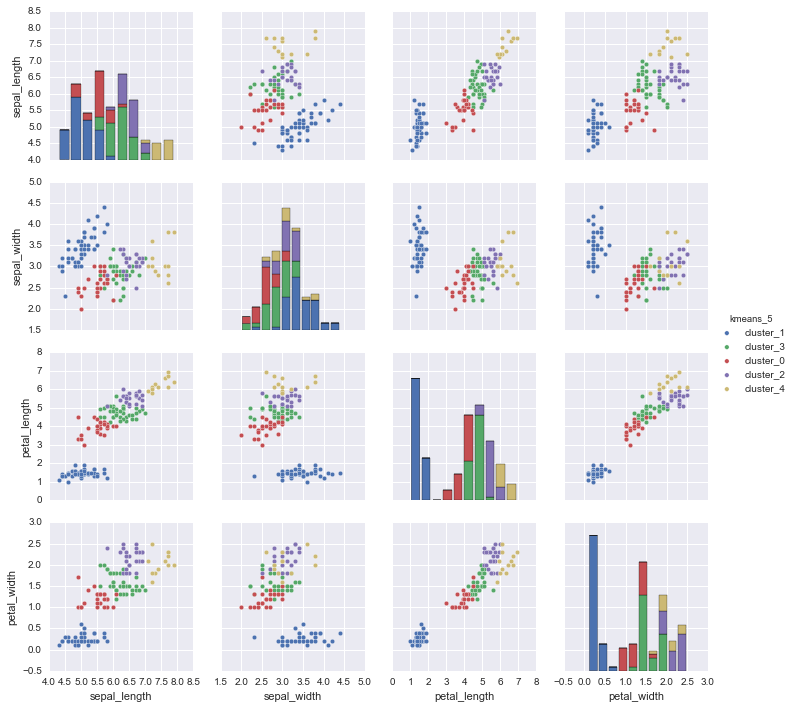

In [32]:
# 5 clusters
kmeans_5 = KMeans(n_clusters=5,random_state=1234)
kmeans_5.fit(iris_data_no_names[iris_data_features])
iris_data_no_names["kmeans_5"] = ["cluster_"+str(label) for label in kmeans_5.labels_]  
# we're adding a new column to the dataset
print(iris_data_no_names.dtypes)       
sns.pairplot(iris_data_no_names,hue="kmeans_5");
print("Cluster centers found by k-means:\n" + ", ".join(iris_data_features) + "\n",
      kmeans_5.cluster_centers_)
iris_5_cluster_centers = iris_data_no_names.groupby("kmeans_5").mean()
print("Means of each column :\n",iris_5_cluster_centers.values)
print("--------------------")
print(iris_5_cluster_centers)
print("--------------------")
print(iris_5_cluster_centers.mean())

[[-1.30780521  0.19950386 -1.30839757 -1.28911786]
 [ 0.38167879 -0.39095084  0.60882357  0.56579901]
 [-0.72135272  1.5070215  -1.30157708 -1.22066912]
 [-0.35279167 -1.33300609  0.10294988  0.01232382]
 [ 1.39733017  0.23316022  1.16062026  1.21734049]]
[2 0 0 0 2 2 0 0 0 0 2 0 0 0 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 0 0 2 2 2 0 0 2
 2 0 0 2 0 0 2 2 0 2 0 2 0 4 1 4 3 1 1 1 3 1 3 3 1 3 1 3 1 1 3 3 3 1 1 1 1
 1 1 1 1 1 3 3 3 3 1 1 1 1 3 1 3 3 1 3 3 3 1 1 1 3 3 4 1 4 1 4 4 3 4 1 4 4
 1 4 1 1 4 1 4 4 3 4 1 4 1 4 4 1 1 1 4 4 4 1 1 1 4 4 1 1 4 4 4 1 4 4 4 1 1
 4 1]


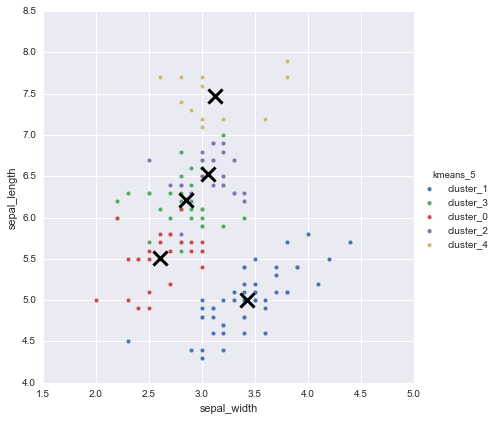

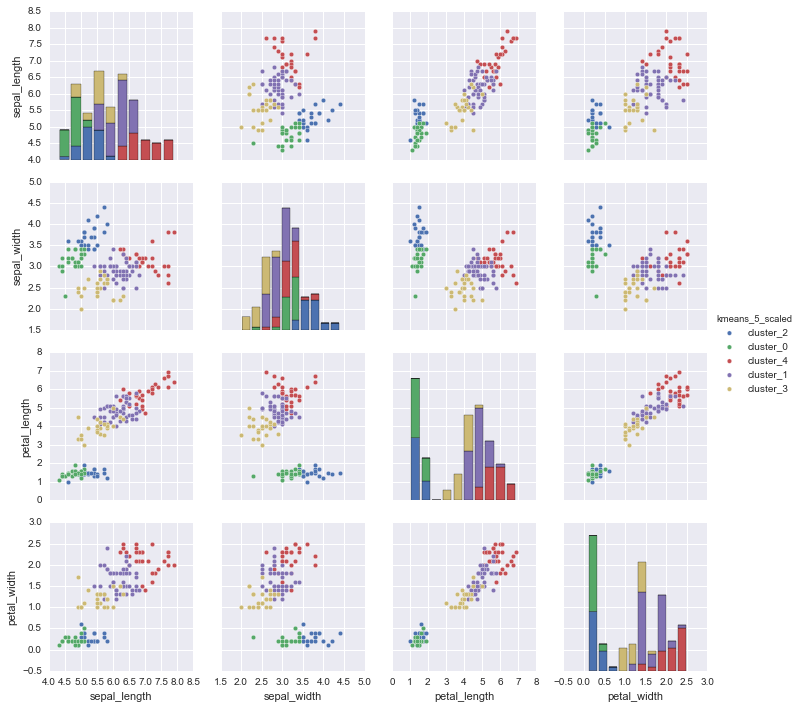

In [33]:
sns.pairplot(iris_data_no_names,x_vars="sepal_width",y_vars="sepal_length",hue="kmeans_5",size=6)
plt.scatter(iris_5_cluster_centers.sepal_width, iris_5_cluster_centers.sepal_length, linewidths=3, marker='x', s=200, c='black');
km_5 = KMeans(n_clusters=5,random_state=1234)
km_5.fit(iris_data_scaled)  # we train the model here
iris_data_no_names['kmeans_5_scaled'] = [ "cluster_" + str(label) for label in km_5.labels_ ]
print(km_5.cluster_centers_)
print(km_5.labels_)
iris_data_no_names.groupby('kmeans_5_scaled').mean().reset_index()
sns.pairplot(iris_data_no_names,hue="kmeans_5_scaled");  # to see what's really going on

sepal_length       float64
sepal_width        float64
petal_length       float64
petal_width        float64
kmeans_2            object
kmeans_2_scaled     object
kmeans_3_scaled     object
kmeans_4            object
kmeans_4_scaled     object
kmeans_5            object
kmeans_5_scaled     object
kmeans_6            object
dtype: object
Cluster centers found by k-means:
sepal_length, sepal_width, petal_length, petal_width
 [[ 6.22972973  2.85135135  4.76756757  1.57297297]
 [ 4.70454545  3.12272727  1.41363636  0.2       ]
 [ 7.475       3.125       6.3         2.05      ]
 [ 6.52916667  3.05833333  5.50833333  2.1625    ]
 [ 5.52962963  2.62222222  3.94074074  1.21851852]
 [ 5.24285714  3.66785714  1.5         0.28214286]]
Means of each column :
 [[ 6.22972973  2.85135135  4.76756757  1.57297297]
 [ 4.70454545  3.12272727  1.41363636  0.2       ]
 [ 7.475       3.125       6.3         2.05      ]
 [ 6.52916667  3.05833333  5.50833333  2.1625    ]
 [ 5.52962963  2.62222222  3.94074074  

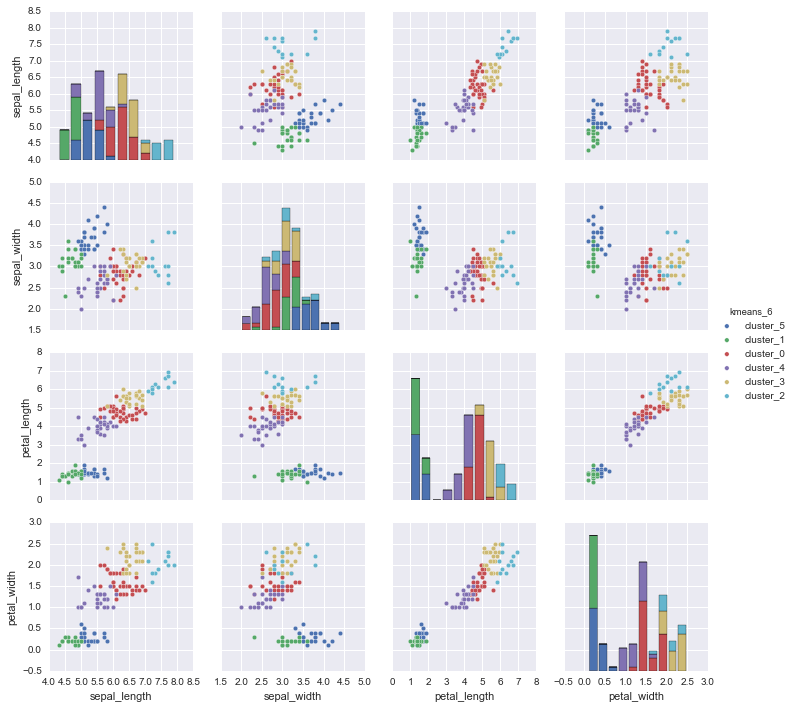

In [34]:
# 6 Clusters
kmeans_6 = KMeans(n_clusters=6,random_state=1234)
kmeans_6.fit(iris_data_no_names[iris_data_features])
iris_data_no_names["kmeans_6"] = ["cluster_"+str(label) for label in kmeans_6.labels_]  
# we're adding a new column to the dataset
print(iris_data_no_names.dtypes)       
sns.pairplot(iris_data_no_names,hue="kmeans_6");
print("Cluster centers found by k-means:\n" + ", ".join(iris_data_features) + "\n",
      kmeans_6.cluster_centers_)
iris_6_cluster_centers = iris_data_no_names.groupby("kmeans_6").mean()
print("Means of each column :\n",iris_6_cluster_centers.values)
print("--------------------")
print(iris_6_cluster_centers)
print("--------------------")
print(iris_6_cluster_centers.mean())

[[-1.30780521  0.19950386 -1.30839757 -1.28911786]
 [ 0.38167879 -0.39095084  0.60882357  0.56579901]
 [-0.72135272  1.5070215  -1.30157708 -1.22066912]
 [-0.35279167 -1.33300609  0.10294988  0.01232382]
 [ 1.39733017  0.23316022  1.16062026  1.21734049]]
[2 0 0 0 2 2 0 0 0 0 2 0 0 0 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 0 0 2 2 2 0 0 2
 2 0 0 2 0 0 2 2 0 2 0 2 0 4 1 4 3 1 1 1 3 1 3 3 1 3 1 3 1 1 3 3 3 1 1 1 1
 1 1 1 1 1 3 3 3 3 1 1 1 1 3 1 3 3 1 3 3 3 1 1 1 3 3 4 1 4 1 4 4 3 4 1 4 4
 1 4 1 1 4 1 4 4 3 4 1 4 1 4 4 1 1 1 4 4 4 1 1 1 4 4 1 1 4 4 4 1 4 4 4 1 1
 4 1]
   sepal_length  sepal_width  petal_length  petal_width   kmeans_2  \
0           5.1          3.5           1.4          0.2  cluster_0   
1           4.9          3.0           1.4          0.2  cluster_0   
2           4.7          3.2           1.3          0.2  cluster_0   
3           4.6          3.1           1.5          0.2  cluster_0   
4           5.0          3.6           1.4          0.2  cluster_0   

  kmeans_2_scaled

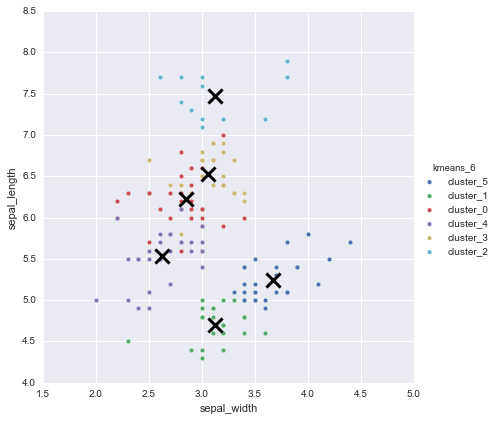

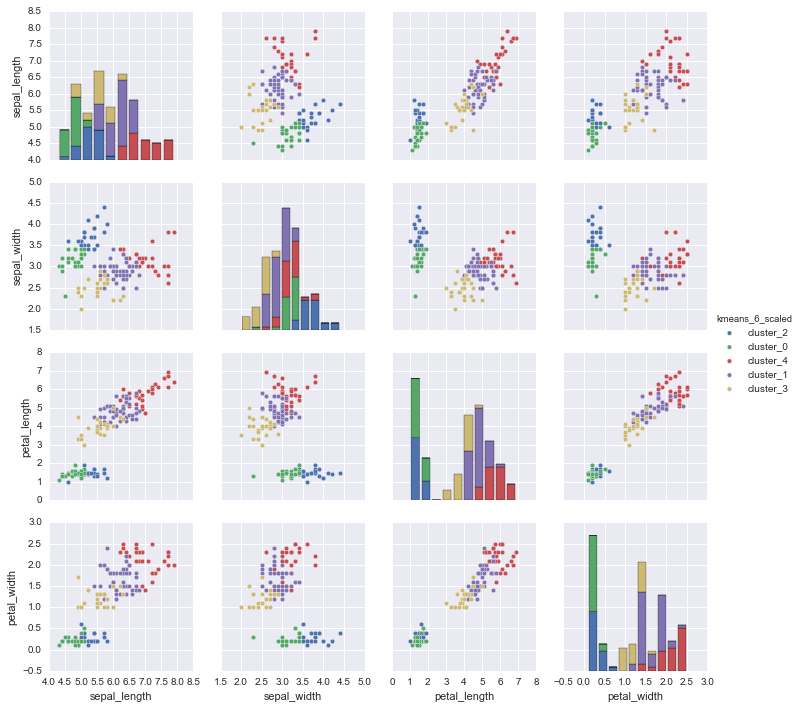

In [35]:
sns.pairplot(iris_data_no_names,x_vars="sepal_width",y_vars="sepal_length",hue="kmeans_6",size=6)
plt.scatter(iris_6_cluster_centers.sepal_width, iris_6_cluster_centers.sepal_length, linewidths=3, marker='x', s=200, c='black');
km_6 = KMeans(n_clusters=5,random_state=1234)
km_6.fit(iris_data_scaled)  # we train the model here
iris_data_no_names['kmeans_6_scaled'] = [ "cluster_" + str(label) for label in km_6.labels_ ]
print(km_6.cluster_centers_)
print(km_6.labels_)
iris_data_no_names.groupby('kmeans_6_scaled').mean().reset_index()
sns.pairplot(iris_data_no_names,hue="kmeans_6_scaled");  # to see what's really going on
print(iris_data_no_names.head())

### Using silhouette coefficient to evalualte quality of clustering

The [**Silhouette Coefficient**](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) is a common metric for evaluating clustering "performance" in situations when the "true" cluster assignments are not known.

A Silhouette Coefficient is calculated for each observation:

$$ SC=\frac {b−a}{max(a,b)}$$

a = mean distance to all other points in its cluster
b = mean distance to all other points in the next nearest cluster
It ranges from -1 (worst) to 1 (best). A global score is calculated by taking the mean score for all observations.

Let's calculate the silhouette coefficient for our original clustering (when k=2):

In [36]:
print("Silhouette score when k=2:",silhouette_score(iris_data_scaled, km.labels_))  # we call this function, which 
# takes the original data and then the identification (labels)

Silhouette score when k=2: 0.581750049198


Now let's calculate and plot the silhouette score for between 1 and 15 clusters:

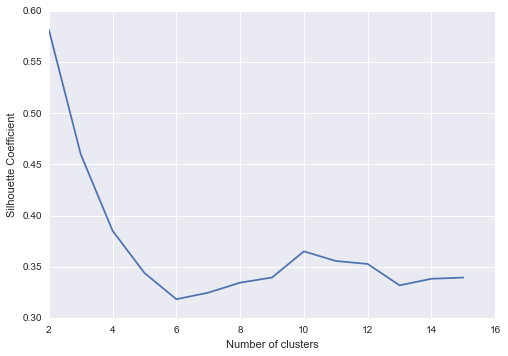

In [37]:
k_range = range(2,16)   # we take all the values in this range  -- I think this is like the exercise
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(iris_data_scaled)
    scores.append(silhouette_score(iris_data_scaled, km_ss.labels_))   # adding a new calculated score to our list

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient');
# These kind of plots are sometimes called elbow plots

#### Exercise Time!!!

I've provided you with the following [seeds dataset](https://archive.ics.uci.edu/ml/datasets/seeds). Each row in the dataset is an individual seed. The individual columns are as follows:
  1. seed area A
  2. seed perimeter P 
  3. compactness $C = 4*\pi*(\frac {A}{P})^2$
  4. length of kernel 
  5. width of kernel 
  6. asymmetry coefficient 
  7. length of kernel groove
  
In the data I've loaded in, I've explicitly removed the seed labeling so that you can explore the data yourself.

Please do the following:
  * Perform clustering using a variety of cluster sizes
  * Calculate the silhouette score for each cluster size and determine an optimal cluster number
  * Visualize the clustering and compute statistics on those clusters. What distinguishes each cluster you've created?

In [38]:
# The seed dataset is described here: https://archive.ics.uci.edu/ml/datasets/seeds
# Data Set Information:
# The examined group comprised kernels belonging to three different varieties of wheat: Kama, Rosa and Canadian, 
# 70 elements each, randomly selected for the experiment. High quality visualization of the internal kernel structure
# was detected using a soft X-ray technique. It is non-destructive and considerably cheaper than other more 
# sophisticated imaging techniques like scanning microscopy or laser technology. The images were recorded on 13x18 cm 
# X-ray KODAK plates. Studies were conducted using combine harvested wheat grain originating from experimental fields,
# explored at the Institute of Agrophysics of the Polish Academy of Sciences in Lublin. 

# The data set can be used for the tasks of classification and cluster analysis.


seed_data = pd.read_csv("../data/seeds_dataset.txt",names=["area","perimeter","compactness","length","width","asymmetry","kernel_groove_length","seed_type"])
seed_data.drop("seed_type",axis=1,inplace=True)
print(seed_data.head())
# seed_data_no_names = seed_data.drop("seed_type",axis=1)
seed_data_features = seed_data.columns
print(seed_data_features)

    area  perimeter  compactness  length  width  asymmetry  \
0  15.26      14.84       0.8710   5.763  3.312      2.221   
1  14.88      14.57       0.8811   5.554  3.333      1.018   
2  14.29      14.09       0.9050   5.291  3.337      2.699   
3  13.84      13.94       0.8955   5.324  3.379      2.259   
4  16.14      14.99       0.9034   5.658  3.562      1.355   

   kernel_groove_length  
0                 5.220  
1                 4.956  
2                 4.825  
3                 4.805  
4                 5.175  
Index([u'area', u'perimeter', u'compactness', u'length', u'width',
       u'asymmetry', u'kernel_groove_length'],
      dtype='object')


In [39]:
# center and scale the data
scaler = StandardScaler()   # we create a StandardScalar
seed_data_scaled = scaler.fit_transform(seed_data[seed_data_features])
seed_data_scaled = pd.DataFrame(seed_data_scaled,columns=seed_data_features)
print("Before scaling:\n", seed_data[seed_data_features].describe())   # printing out some descriptive stats
print("\nAfter scaling:\n", np.round(seed_data_scaled.describe(),2))      # we subtracted out the mean from every col.
print("seed_data_scaled:\n", seed_data_scaled.head())

Before scaling:
              area   perimeter  compactness      length       width  \
count  210.000000  210.000000   210.000000  210.000000  210.000000   
mean    14.847524   14.559286     0.870999    5.628533    3.258605   
std      2.909699    1.305959     0.023629    0.443063    0.377714   
min     10.590000   12.410000     0.808100    4.899000    2.630000   
25%     12.270000   13.450000     0.856900    5.262250    2.944000   
50%     14.355000   14.320000     0.873450    5.523500    3.237000   
75%     17.305000   15.715000     0.887775    5.979750    3.561750   
max     21.180000   17.250000     0.918300    6.675000    4.033000   

        asymmetry  kernel_groove_length  
count  210.000000            210.000000  
mean     3.700201              5.408071  
std      1.503557              0.491480  
min      0.765100              4.519000  
25%      2.561500              5.045000  
50%      3.599000              5.223000  
75%      4.768750              5.877000  
max      8.45600

0.465772476866
0.400727055275
0.336900822971
0.286197422409
0.286573877636
0.271945312334
0.275210849778
0.26069335906
0.247885817992
0.259654904145
0.250424495166
0.254883999909
0.245867713905
0.238188354719


[0.4657724768658093,
 0.40072705527512986,
 0.33690082297108531,
 0.28619742240883067,
 0.28657387763634379,
 0.27194531233381181,
 0.27521084977753696,
 0.26069335905991553,
 0.24788581799234627,
 0.25965490414493564,
 0.25042449516615911,
 0.25488399990857613,
 0.24586771390532425,
 0.23818835471850128]

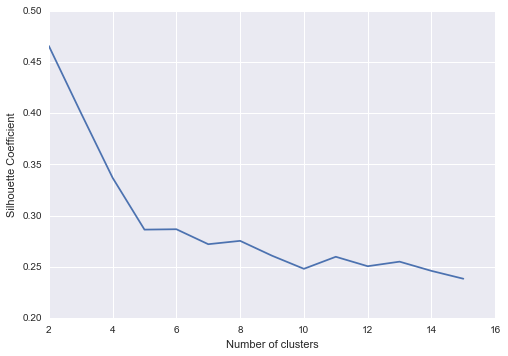

In [40]:
# pass
k_range = range(2,16)   # we take all the values in this range  -- I think this is like the exercise
scores_seed = []
for k in k_range:
    km_ss_seed = KMeans(n_clusters=k, random_state=1)
    km_ss_seed.fit(seed_data_scaled)
    scores_seed.append(silhouette_score(seed_data_scaled, km_ss_seed.labels_))   # adding a new calculated score to 
    print(silhouette_score(seed_data_scaled, km_ss_seed.labels_))                                                                            #our list

# plot the results
plt.plot(k_range, scores_seed)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient');
# These kind of plots are sometimes called elbow plots
scores_seed

In [44]:
km_ss_seed.labels_

array([11, 11, 14, 14,  0, 14,  6, 14,  8,  0,  6, 11, 14,  6, 11, 14, 14,
        0, 14,  1,  6, 11,  0,  4, 11,  0,  4,  4, 11,  6,  4,  6,  6, 11,
       11,  0,  8,  0,  6,  5, 14, 11, 14,  8,  0, 11,  0,  0, 11, 11,  6,
        6,  6,  6, 11, 11, 11,  0,  0,  4,  4,  4, 14,  6,  4, 14, 11, 11,
       11,  3,  8,  8,  8,  2,  8,  8,  8,  9,  9,  8,  8, 12, 12, 13, 13,
        2,  2,  9, 12, 12, 13,  2,  2, 12,  9,  8, 13, 13, 13, 13,  8,  2,
       12, 13, 13,  2,  2,  8,  9,  2,  2, 13,  2, 12, 12, 13,  2,  2,  2,
       13, 12,  8,  8,  2,  0,  2,  9,  2, 13,  8,  2,  2,  8,  8,  8,  0,
        8,  8,  8,  8,  7,  7,  7,  7,  3, 10,  3,  1,  3, 10,  7, 10,  3,
        3,  3, 10,  1, 10, 10, 10,  3,  3,  3,  7,  7,  4,  7,  3,  3,  3,
       10,  7,  3, 10, 10,  1, 10, 10,  7,  4,  1,  7,  7,  7,  7,  3, 10,
        3,  7,  1, 10,  1,  1, 10,  1,  1,  7,  6,  3, 14,  7, 14,  1,  5,
        1,  1,  1,  5,  1,  7], dtype=int32)

In [45]:
print("Silhouette score when k=15:",silhouette_score(seed_data_scaled, km_ss_seed.labels_))  
# we call this function, which takes the original data and then the identification (labels)

Silhouette score when k=15: 0.238188354719


### Weaknesses of kmeans:

1. Assumes roughly equal-sized (in distance) clusters
2. Assumes spherical shape
3. Always assigns points to clusters
4. Randomness means that best solution isn't guaranteed

![Kmeans with different-sized clusters](../images/kms1.png)

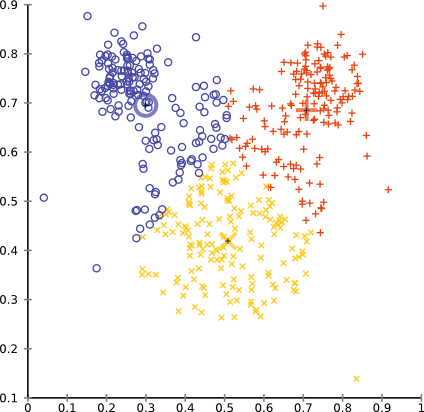

In [89]:
Image(filename='../images/kms1.png')

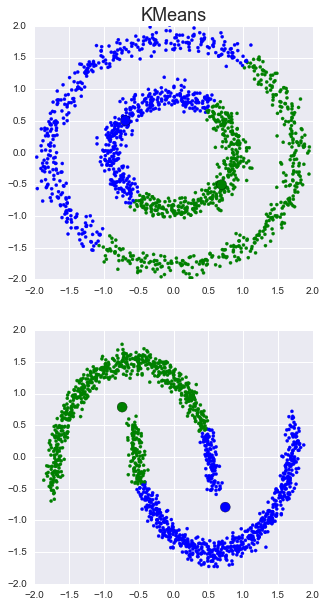

In [46]:
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times. 
# Note that data sets have been imported 
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,    
                                      noise=.05)    # we're adding some noise
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = ['KMeans']
   
plt.figure(figsize=(5,10))

all_dataset = [noisy_circles, noisy_moons]

for i_dataset, dataset in enumerate(all_dataset):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=2).fit(X)
    
    clustering_algorithms = [kmeans]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        algorithm.fit(X)
        y_pred = algorithm.labels_

        # plot
        plt.subplot(2, 1, i_dataset+1)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred], s=10)
        
        centers = algorithm.cluster_centers_
        center_colors = colors[:len(centers)]
        plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)

plt.show()  # we see cases here where KMeans has failed... where some of the assumptions have failed here

### DBSCAN

The second clustering algorithm we are going to investigate is called **DBSCAN** and works a bit differently than K-means.[DBSCAN wiki](https://en.wikipedia.org/wiki/DBSCAN)

**DBSCAN** stands for **Density-based spatial clustering of applications with noise**.

Whereas K-means does not care about the density of data, **DBSCAN** does, under the assumption that **regions of high density in your data should be treated as clusters**.

Furthermore, **DBSCAN does not allow you to specify how many clusters you want.** Instead, you specify 2 parameters:
  1. **$\epsilon$ (epsilon)**: This is the maximum distance between two points to allow them to be neighbors
  2. **min_samples**: The number of neighbors a given point is allowed to have to be able to be part of a cluster

Any points that don't satisfy the criteria of being close enough to other points are labeled outliers and all fall into a single "cluster" (their cluster label by default is -1).

DBSCAN works as follows:
  1. Choose an arbitrary starting point in your dataset that has not been seen.
  2. Retrieve this point's $\epsilon$-neighborhood (all points that are within a distance **$\epsilon$** from it), and if it contains at least ***min_samples**, a cluster is started.
  3. Otherwise, the point is labeled as an outlier (-1). **Note: This point might later be found in a sufficiently sized ε-environment of a different point and hence be made part of a cluster.**
  4. If a point is found to be a dense part of a cluster, its $\epsilon$-neighborhood is also part of that cluster. All points that are found within the $\epsilon$-neighborhood are added, as is their own $\epsilon$-neighborhood when they are also dense.
  5. Continue until the density-connected cluster is completely found.
  6. Find a new unvisited point to process, rinse and repeat.

There are 2 very big differences between **DBSCAN** and **K-means** clustering:
  1. **DBSCAN determines the number of clusters automatically whereas K-means requires #of clusters as a parameter.**
  2. **DBSCAN takes any distance metric you want, whereas K-means only works with euclidean distance.**
  
What this means in practice is that **DBSCAN** is very sensitive to:
  1. what distance metric you choose
  2. what you set $\epsilon$ and **min_samples** to

Let's work through using DBSCAN on the Iris dataset, and see what happens when we use 

First, we create a DBSCAN object, then we fit it to our scaled iris data. By default, DBSCAN uses euclidean distance:

In [48]:
db = DBSCAN(eps=1, min_samples=3)  # create a DBSCAN object
db.fit(iris_data_scaled)   # we fit the DBSCAN object to our scaled iris data
print(iris_data_scaled.head())
print(db)

   sepal_length  sepal_width  petal_length  petal_width
0     -0.900681     1.019004     -1.340227    -1.315444
1     -1.143017    -0.131979     -1.340227    -1.315444
2     -1.385353     0.328414     -1.397064    -1.315444
3     -1.506521     0.098217     -1.283389    -1.315444
4     -1.021849     1.249201     -1.340227    -1.315444
DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)


In [49]:
db.labels_     # this is similar to the case of kmeans_  

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

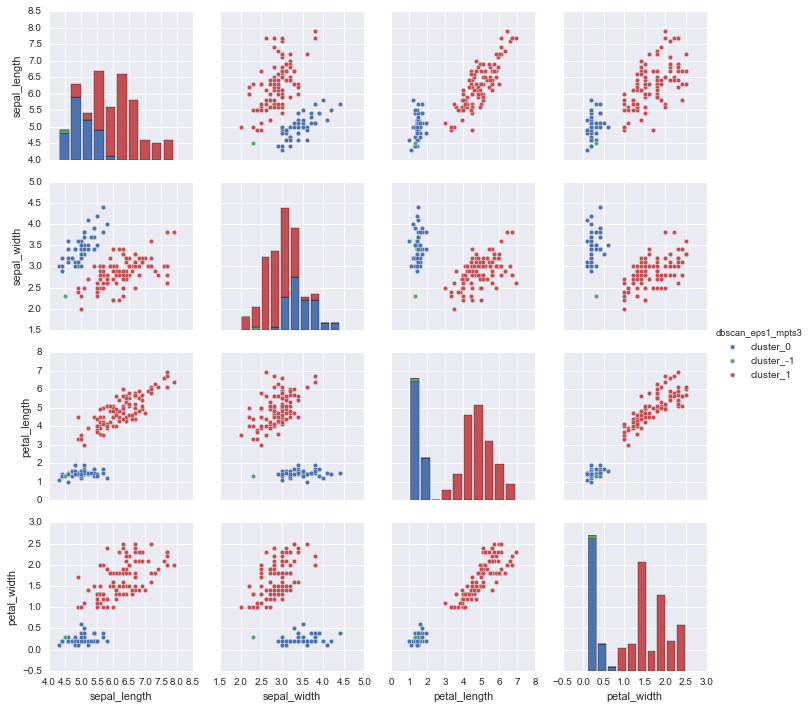

In [50]:
iris_data_no_names['dbscan_eps1_mpts3'] = [ "cluster_" + str(label) for label in db.labels_ ]
# Recall that we set eps=1  and min_samples=3 here 
sns.pairplot(iris_data_no_names,hue="dbscan_eps1_mpts3");  # we're looking at 2D plots of higher-dimensional data

What happens as we alter either $\epsilon$ or min_samples?

Let's first alter min_samples:

In [51]:
db2 = DBSCAN(eps=1, min_samples=10)   # we're increasing the number of samples here but keeping eps=1
db2.fit(iris_data_scaled)
db2.labels_    # we have more -1 values --   i.e., more outliers
# if min_samples is higher, we end up with more outliers

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

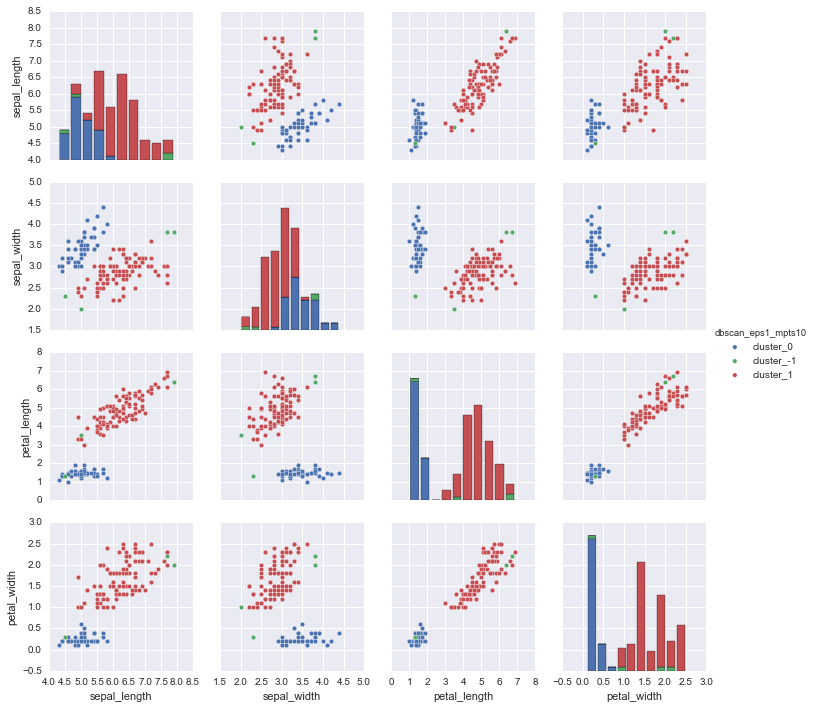

In [53]:
iris_data_no_names['dbscan_eps1_mpts10'] = [ "cluster_" + str(label) for label in db2.labels_ ]
# Here we have eps=1 and min_samples=10
sns.pairplot(iris_data_no_names,hue="dbscan_eps1_mpts10");

So, as we increase **min_samples**, we get more outliers. This makes sense, as increasing the number of points needed to make a cluster becomes harder the larger the number of points we need.

Points that are themselves far away from large collections of points now become outliers.

What about when we increase $\epsilon$?

In [54]:
db3 = DBSCAN(eps=2, min_samples=3)   # we doubled the minimum distance to eps=2 and set min_samples=3
db3.fit(iris_data_scaled)
db3.labels_
# there don't appear to be any outliers here

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

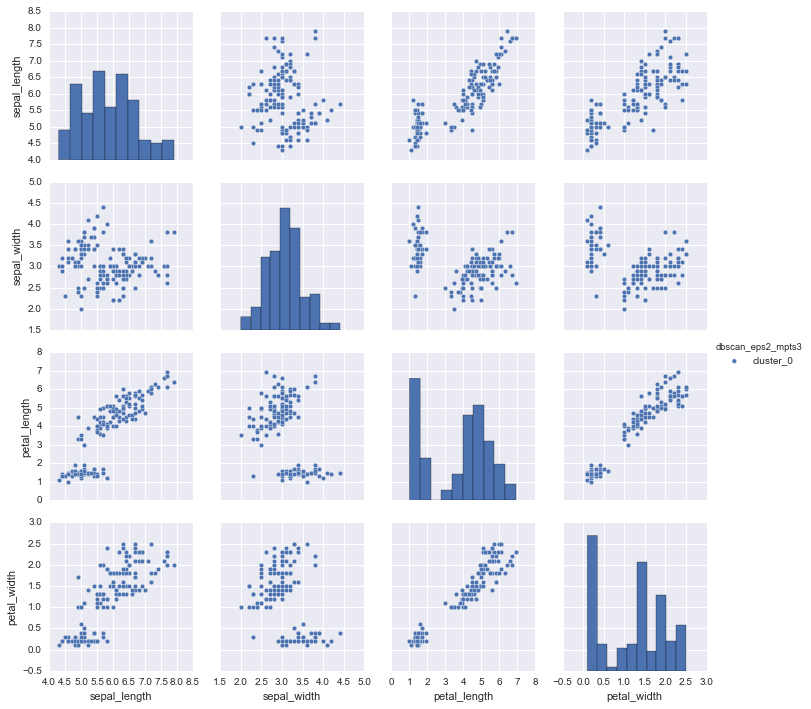

In [55]:
iris_data_no_names['dbscan_eps2_mpts3'] = [ "cluster_" + str(label) for label in db3.labels_ ]
sns.pairplot(iris_data_no_names,hue="dbscan_eps2_mpts3");

So, increasing $\epsilon$ has a different effect from increasing **min_samples**, in that it causes clusters to be merged.

This should make sense to you, because as you increase the distance for any points to be $\epsilon$-connected, it becomes easier to force distant points to be part of the same cluster.

Just to hammer this home, lets try to cluster our dataset using a smaller $\epsilon$, to illustrate that it causes more clusters to form:

In [57]:
db4 = DBSCAN(eps=0.6, min_samples=3)  # if we make eps smaller, we should get more clusters
db4.fit(iris_data_scaled)
db4.labels_
# We also see that there are more outliers here

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

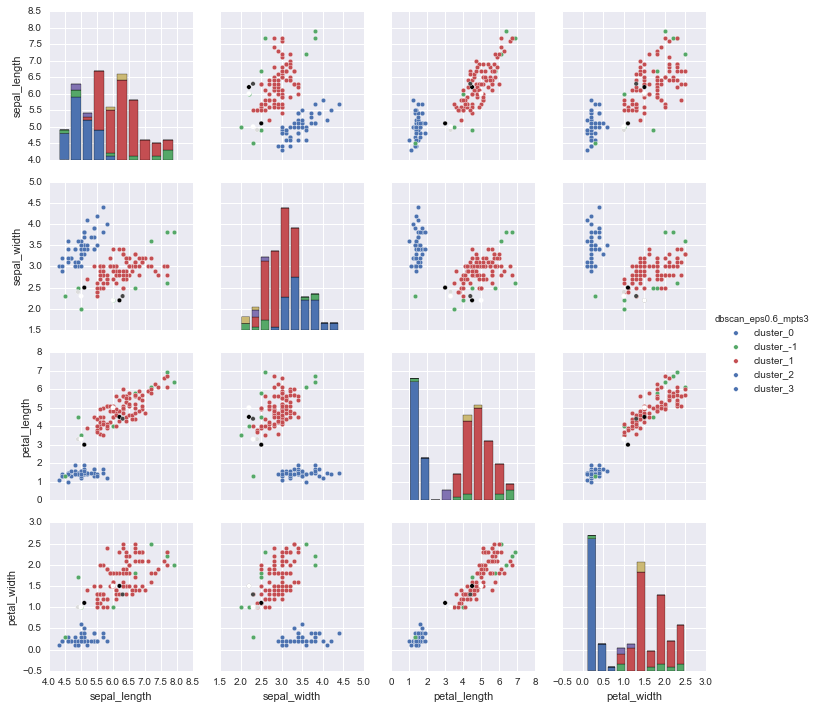

In [58]:
iris_data_no_names['dbscan_eps0.6_mpts3'] = [ "cluster_" + str(label) for label in db4.labels_ ]
# Here we have eps=0.6 and min_samples=3
sns.pairplot(iris_data_no_names,hue="dbscan_eps0.6_mpts3");   # 4 clusters have now been identified

### k-means vs DBSCAN

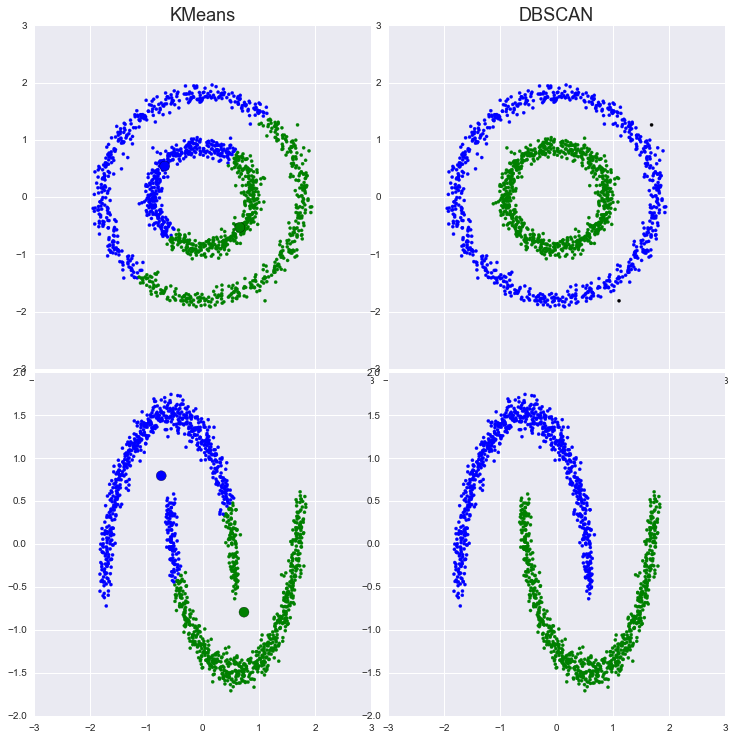

In [59]:
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)


colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = ['KMeans', 'DBSCAN']

plt.figure(figsize=(10,10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

all_datasets = [noisy_circles, noisy_moons]

for i_dataset, dataset in enumerate(all_datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=2)
    dbscan = DBSCAN(eps=.2)
    clustering_algorithms = [kmeans, dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(2, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
            
        plot_num += 1

plt.show()

Clustering comparison code is adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

#### Exercise Time!!!

Using the seeds dataset we looked at above, please do the following:
  * Perform clustering using a variety of $\epsilon$ and **min_samples** values
  * Calculate the silhouette score for each group of parameters and determine an optimal configuration
  * Visualize the clustering and compute statistics on those clusters. What distinguishes each cluster you've created?

In [78]:
# pass
db_eps1_mpts9 = DBSCAN(eps=1, min_samples=9)   # eps=1 and min_samples=9
db_eps1_mpts9.fit(seed_data_scaled)
db_eps1_mpts9.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0, -1, -1,
       -1, -1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0, -1,  0,  0, -1, -1,  0,  0,  0,  0,  0,  0,  0,
       -1, -1,  0,  0,  0,  0, -1,  0, -1,  0, -1, -1,  0,  0, -1,  0,  0,
        0,  0,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1,  0,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  0,
        1, -1, -1,  1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0, -1,
        0,  0,  0, -1,  0,  0])

area                    float64
perimeter               float64
compactness             float64
length                  float64
width                   float64
asymmetry               float64
kernel_groove_length    float64
db_eps2_mpts4            object
db_eps2_mpts9            object
db_eps1_mpts9            object
dtype: object
    area  perimeter  compactness  length  width  asymmetry  \
0  15.26      14.84       0.8710   5.763  3.312      2.221   
1  14.88      14.57       0.8811   5.554  3.333      1.018   
2  14.29      14.09       0.9050   5.291  3.337      2.699   
3  13.84      13.94       0.8955   5.324  3.379      2.259   
4  16.14      14.99       0.9034   5.658  3.562      1.355   

   kernel_groove_length db_eps2_mpts4 db_eps2_mpts9 db_eps1_mpts9  
0                 5.220     cluster_0     cluster_0     cluster_0  
1                 4.956     cluster_0     cluster_0     cluster_0  
2                 4.825     cluster_0     cluster_0     cluster_0  
3                 4.8

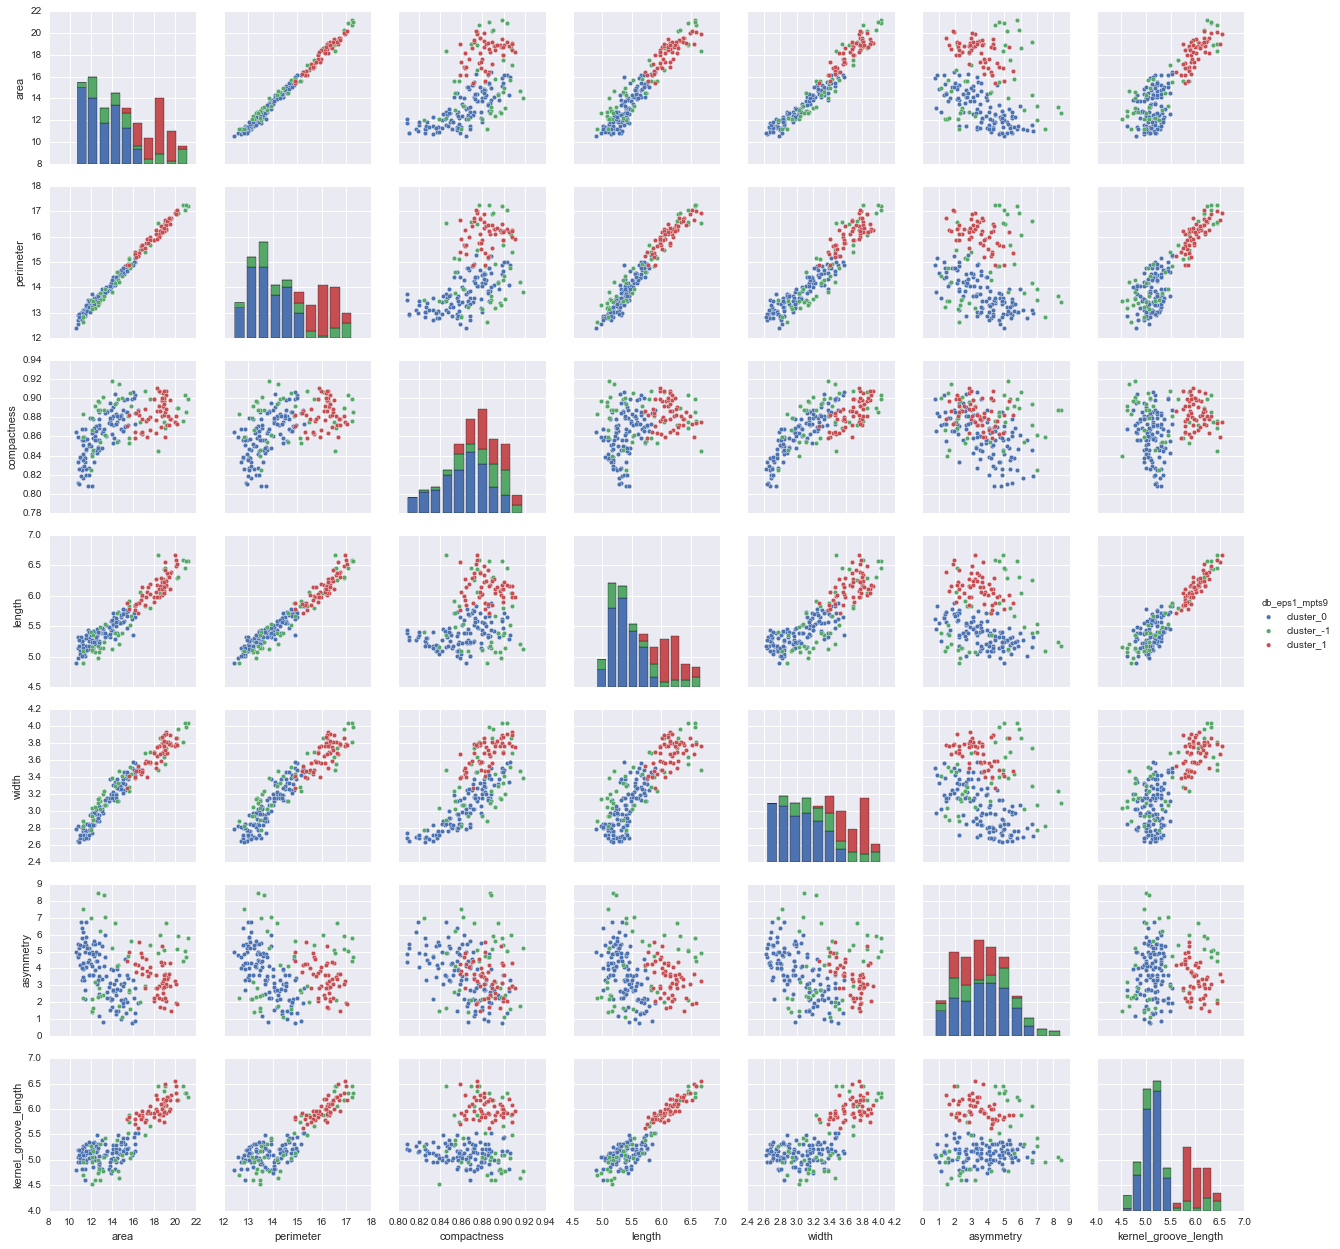

In [79]:
seed_data["db_eps1_mpts9"] = ["cluster_"+str(label) for label in db_eps1_mpts9.labels_]  # We're adding a new column to
# the dataset
print(seed_data.dtypes) 
print(seed_data.head())
print(db_eps1_mpts9.labels_)
sns.pairplot(seed_data,hue="db_eps1_mpts9");
print("Silhouette score when eps=1, min_samples=9 :",silhouette_score(seed_data_scaled, db_eps1_mpts9.labels_))

area                    float64
perimeter               float64
compactness             float64
length                  float64
width                   float64
asymmetry               float64
kernel_groove_length    float64
db_eps2_mpts4            object
db_eps2_mpts9            object
db_eps1_mpts9            object
db_eps1_mpts4            object
dtype: object
    area  perimeter  compactness  length  width  asymmetry  \
0  15.26      14.84       0.8710   5.763  3.312      2.221   
1  14.88      14.57       0.8811   5.554  3.333      1.018   
2  14.29      14.09       0.9050   5.291  3.337      2.699   
3  13.84      13.94       0.8955   5.324  3.379      2.259   
4  16.14      14.99       0.9034   5.658  3.562      1.355   

   kernel_groove_length db_eps2_mpts4 db_eps2_mpts9 db_eps1_mpts9  \
0                 5.220     cluster_0     cluster_0     cluster_0   
1                 4.956     cluster_0     cluster_0     cluster_0   
2                 4.825     cluster_0     cluster_0   

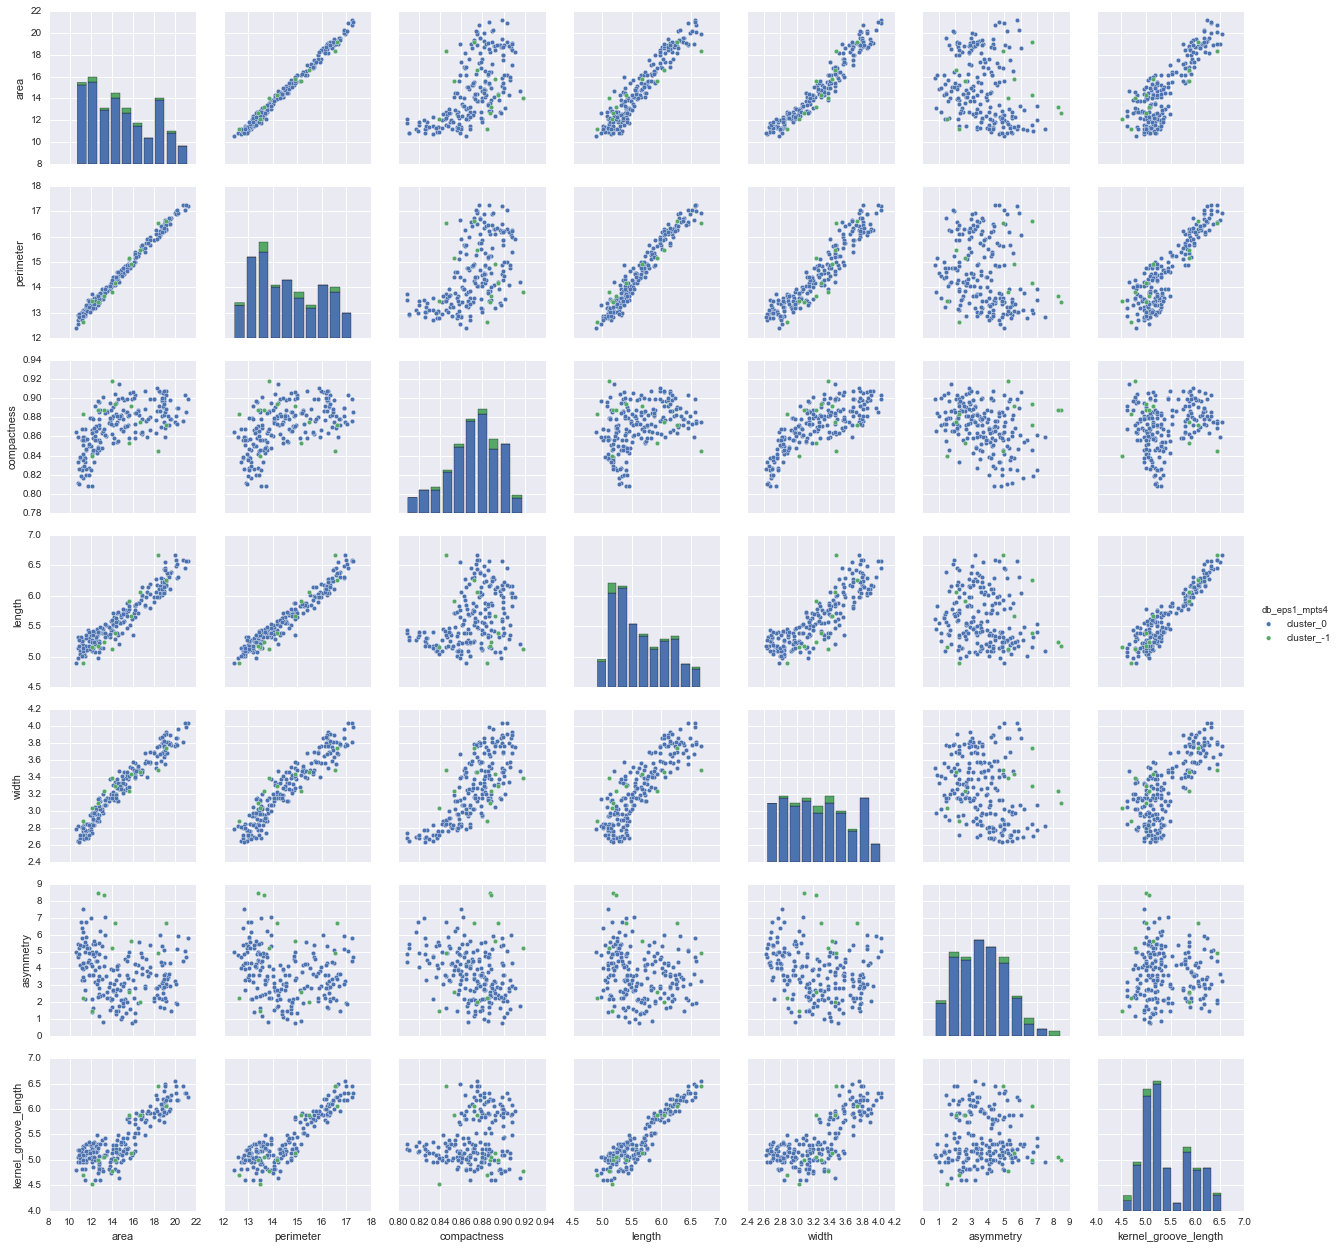

In [80]:
db_eps1_mpts4 = DBSCAN(eps=1, min_samples=4)   # eps=1 and min_samples=4
db_eps1_mpts4.fit(seed_data_scaled)
db_eps1_mpts4.labels_
seed_data["db_eps1_mpts4"] = ["cluster_"+str(label) for label in db_eps1_mpts4.labels_]  # We're adding a new column to
# the dataset
print(seed_data.dtypes) 
print(seed_data.head())
print(db_eps1_mpts4.labels_)   # we see that there are fewer outliers here
sns.pairplot(seed_data,hue="db_eps1_mpts4");
print("Silhouette score when eps=1, min_samples=4 :",silhouette_score(seed_data_scaled, db_eps1_mpts4.labels_))

area                    float64
perimeter               float64
compactness             float64
length                  float64
width                   float64
asymmetry               float64
kernel_groove_length    float64
db_eps2_mpts4            object
db_eps2_mpts9            object
db_eps1_mpts9            object
db_eps1_mpts4            object
db_eps05_mpts5           object
dtype: object
    area  perimeter  compactness  length  width  asymmetry  \
0  15.26      14.84       0.8710   5.763  3.312      2.221   
1  14.88      14.57       0.8811   5.554  3.333      1.018   
2  14.29      14.09       0.9050   5.291  3.337      2.699   
3  13.84      13.94       0.8955   5.324  3.379      2.259   
4  16.14      14.99       0.9034   5.658  3.562      1.355   

   kernel_groove_length db_eps2_mpts4 db_eps2_mpts9 db_eps1_mpts9  \
0                 5.220     cluster_0     cluster_0     cluster_0   
1                 4.956     cluster_0     cluster_0     cluster_0   
2                 4.82

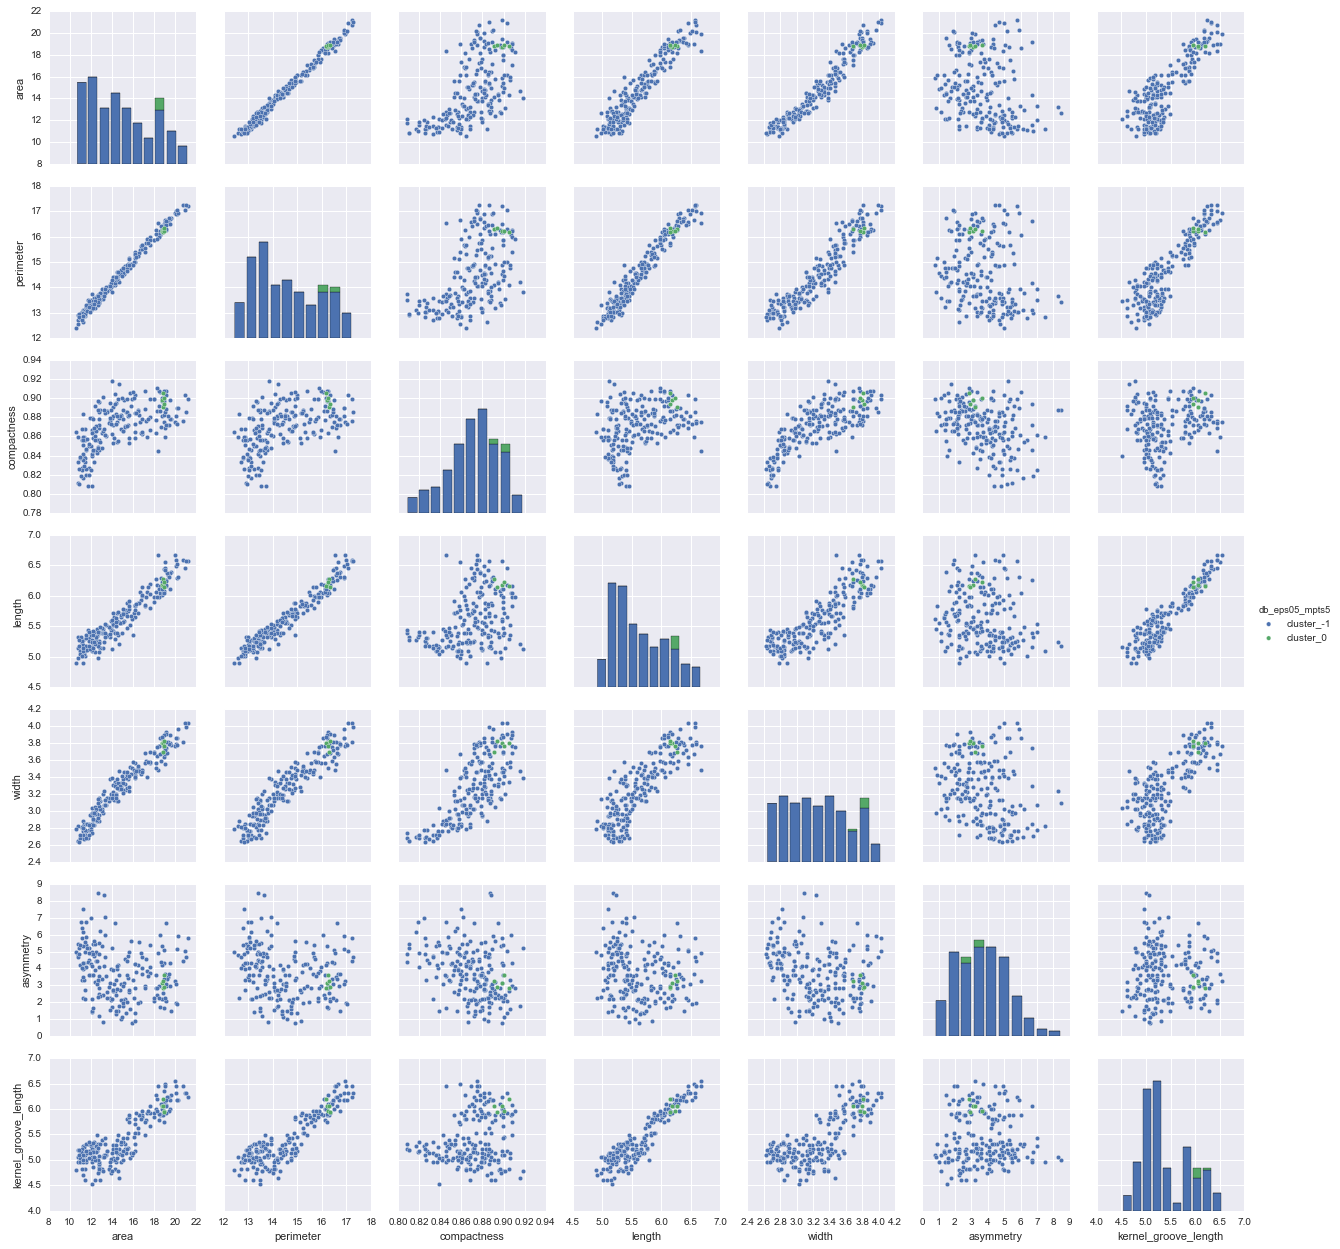

In [82]:
db_eps05_mpts5 = DBSCAN(eps=0.5, min_samples=5)   # eps=1 and min_samples=4
db_eps05_mpts5.fit(seed_data_scaled)
db_eps05_mpts5.labels_
seed_data["db_eps05_mpts5"] = ["cluster_"+str(label) for label in db_eps05_mpts5.labels_]  # We're adding a new column to
# the dataset
print(seed_data.dtypes) 
print(seed_data.head())
print(db_eps05_mpts5.labels_)   # we see that there are fewer outliers here
sns.pairplot(seed_data,hue="db_eps05_mpts5");
print("Silhouette score when eps=0.5, min_samples=5 :",silhouette_score(seed_data_scaled, db_eps05_mpts5.labels_))

-0.0821364642672
-0.0557375681361
0.0246716303477
-0.0165946156976
0.154762256279
0.112324034706
0.0760178765728
0.0940836452004
0.0353250163789
-0.000810528496703
-0.179969327417
-0.260805799211
-0.187597133135
-0.187597133135
-0.140874224302


[-0.082136464267160952,
 -0.055737568136129276,
 0.024671630347719312,
 -0.01659461569761142,
 0.15476225627900345,
 0.11232403470594678,
 0.076017876572800638,
 0.094083645200419785,
 0.035325016378926308,
 -0.00081052849670298324,
 -0.17996932741737065,
 -0.2608057992113379,
 -0.18759713313477203,
 -0.18759713313477203,
 -0.1408742243016872]

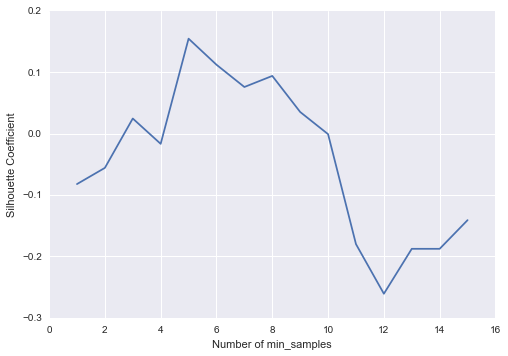

In [83]:
db_eps08_range = range(1,16)   # we take all the values in this range  -- I think this is like the exercise
scores_seed = []
for db in db_eps08_range:
    db_eps08_mpts_range = DBSCAN(eps=0.8, min_samples=db)
    db_eps08_mpts_range.fit(seed_data_scaled)
    scores_seed.append(silhouette_score(seed_data_scaled, db_eps08_mpts_range.labels_))   # adding a new calculated score to 
    print(silhouette_score(seed_data_scaled, db_eps08_mpts_range.labels_))                                                                            #our list

# plot the results
plt.plot(db_eps08_range, scores_seed)
plt.xlabel('Number of min_samples')
plt.ylabel('Silhouette Coefficient');
# These kind of plots are sometimes called elbow plots
scores_seed

[ 0.5         0.57857143  0.65714286  0.73571429  0.81428571  0.89285714
  0.97142857  1.05        1.12857143  1.20714286  1.28571429  1.36428571
  1.44285714  1.52142857  1.6       ]
0.062058138814
-0.326630128409
-0.159439746325
-0.0203288825332
0.155605873717
0.110764737519
0.0855158314664
0.130474299966
0.15580527834
0.159217687182
0.132175917557
0.132175917557
0.193732918202
0.193732918202
0.194833805471


[0.062058138814014521,
 -0.32663012840901701,
 -0.15943974632528793,
 -0.020328882533193975,
 0.15560587371689322,
 0.11076473751899532,
 0.085515831466374009,
 0.13047429996646259,
 0.15580527834045743,
 0.15921768718211449,
 0.13217591755671954,
 0.13217591755671954,
 0.19373291820189056,
 0.19373291820189056,
 0.19483380547087989]

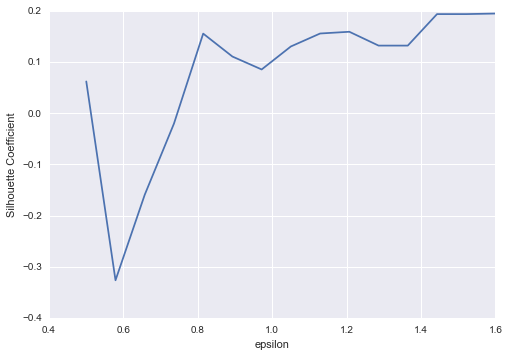

In [112]:
from numpy import linspace
db_range_mpts6 = linspace(0.5, 1.6, 15)   # we take all the values in this range  -- I think this is like the exercise
print(db_range_mpts6)
scores_seed = []
for dbs in db_range_mpts6:
    db_eps_range_mpts6 = DBSCAN(eps=dbs, min_samples=5)
    db_eps_range_mpts6.fit(seed_data_scaled)
    scores_seed.append(silhouette_score(seed_data_scaled, db_eps_range_mpts6.labels_))   # adding a new calculated score to 
    print(silhouette_score(seed_data_scaled, db_eps_range_mpts6.labels_))                                                                            #our list

# plot the results
plt.plot(db_range_mpts6, scores_seed)
plt.xlabel('epsilon')
plt.ylabel('Silhouette Coefficient');
# These kind of plots are sometimes called elbow plots
scores_seed

### When should I use euclidean distance as a distance metric?

Many different kinds of distance metrics exist, but euclidean distance is the most commonly used (and misused) distance metric.

It is useful when:
* All of the features (columns) in your data are numeric
* There are not many feature dimensions (<100)

It is not useful when:
* Columns in your data are composed of either strings or categories, or your columns have both numeric and categorical features.
* You have 1000s of features in your dataset (because of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality))

We will talk about other distance metrics and when they should be used next week.

### Takeaways

**K-means**:
  * is a good off-the-shelf clustering algorithm when youre dealing with numerical data and have some idea of the number of clusters you are looking for in your dataset
  * requires feature scaling
  * requires specifiying the number of clusters
  * can only use the euclidean distance as a distance metric
  * is non-deterministic (will generate different cluster labelings depending on initial conditions)

**DBSCAN**:
  * is a good clustering algorithm when you are attempting to find dense and non-dense regions in your feature space but dont know the number of clusters you're looking for.
  * requires feature scaling
  * requires specifying a distance metric (euclidean is default)
  * requires specifying a minimum distance between points, $\epsilon$
  * requires specifying a minimum number of points to be called a "cluster" (min_samples), minimum is 2
  * is non-deterministic (when points are on the border between two clusters, can be assigned to either one, depending on order in which un-visited points are visited).   